<img src="gullu.jpg" width="300">

### Understanding Datasets
* Link for data - https://www.kaggle.com/c/dog-breed-identification
* train dir contains 10K dogs images
* image name is id of image
* labels.csv contains id vs breed mapping

### Imports

In [1]:
import os
import numpy as np
import pandas as pd
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications import imagenet_utils

import matplotlib.pyplot as plt
%matplotlib inline

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras.callbacks import EarlyStopping

### train dir contains images

In [3]:
base_dir = '.'
data_dir = os.path.join(base_dir,'train')
files = os.listdir(data_dir)

### Target Information from labels.csv

In [4]:
labels = pd.read_csv(os.path.join(base_dir,'labels.csv'))
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [5]:
file_df = pd.DataFrame({'id':list(map(lambda x:x.replace('.jpg',''),files))})
file_df.head()

,id
0,3f06362327d11ca13c01a19182911927
1,28324516db1ad19c3b33c1b6ad397774
2,62b930bc746b25a1a68518194c0ef059
3,82cd7074fe9b46b58a0ef2b74457026b
4,369f1231c318aafcdcb56a0cdd63b5f0


### Mapping File with breed, maintain file read order

In [6]:
label_info = pd.merge(left=file_df, right=labels)
label_info.head()

,id,breed
0,3f06362327d11ca13c01a19182911927,scotch_terrier
1,28324516db1ad19c3b33c1b6ad397774,giant_schnauzer
2,62b930bc746b25a1a68518194c0ef059,chihuahua
3,82cd7074fe9b46b58a0ef2b74457026b,cocker_spaniel
4,369f1231c318aafcdcb56a0cdd63b5f0,appenzeller


### showing a few of them
#### 1st Image

In [7]:
img = plt.imread(os.path.join(data_dir,files[1]))

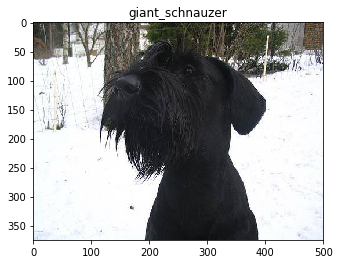

In [8]:
plt.imshow(img)
plt.title(label_info.iloc[1]['breed'])
plt.show()

### Converting target to One-Hot-Vector Format

In [9]:
num_classes = len(label_info.breed.unique())
num_classes

120

In [10]:
le = LabelEncoder()
breed = le.fit_transform(label_info.breed)
Y = np_utils.to_categorical(breed,num_classes=num_classes)

In [11]:
Y.shape

(10222, 120)

### Convert images to numpy array

In [12]:
input_dim = (224, 224)

X = np.zeros((Y.shape[0],*input_dim,3))

for i,img in enumerate(files):
    image = load_img(os.path.join(data_dir,img),target_size=input_dim)
    image = img_to_array(image)
    image = image.reshape((1, *image.shape))
    image = preprocess_input(image)
    X[i] = image

In [13]:
X.shape

(10222, 224, 224, 3)

### Create callbacks

In [17]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')

<img src="https://alexisbcook.github.io/assets/global_average_pooling.png"  height="600" width="600">

In [34]:
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.layers import Dense,GlobalAveragePooling2D, Flatten,Dropout

vgg_model = VGG19(weights='imagenet', include_top=False)

x = vgg_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
out = Dense(120, activation='softmax')(x)

model = Model(inputs=vgg_model.input, outputs=out)

for layer in vgg_model.layers:
    layer.trainable = False

from keras.optimizers import Adam
opt = Adam()

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [35]:
history_last_layer = model.fit(X,Y,batch_size=256,epochs=20,validation_split=0.2,verbose=2,callbacks=[earlystop])
model.save('modellastlayer.h5')

Train on 8177 samples, validate on 2045 samples
Epoch 1/20
 - 135s - loss: 13.4232 - acc: 0.0245 - val_loss: 10.5791 - val_acc: 0.0748
Epoch 2/20
 - 136s - loss: 10.0468 - acc: 0.1228 - val_loss: 7.4871 - val_acc: 0.2264
Epoch 3/20
 - 136s - loss: 7.2840 - acc: 0.2463 - val_loss: 5.8475 - val_acc: 0.3350
Epoch 4/20
 - 136s - loss: 5.7772 - acc: 0.3501 - val_loss: 4.9258 - val_acc: 0.4186
Epoch 5/20
 - 136s - loss: 4.7255 - acc: 0.4338 - val_loss: 4.4194 - val_acc: 0.4489
Epoch 6/20
 - 136s - loss: 4.0151 - acc: 0.4900 - val_loss: 3.7430 - val_acc: 0.4949
Epoch 7/20
 - 136s - loss: 3.4519 - acc: 0.5379 - val_loss: 3.3432 - val_acc: 0.5257
Epoch 8/20
 - 136s - loss: 3.0908 - acc: 0.5706 - val_loss: 3.2381 - val_acc: 0.5506
Epoch 9/20
 - 136s - loss: 2.8388 - acc: 0.6061 - val_loss: 3.1729 - val_acc: 0.5535
Epoch 10/20
 - 136s - loss: 2.5378 - acc: 0.6283 - val_loss: 2.9195 - val_acc: 0.5672
Epoch 11/20
 - 136s - loss: 2.2752 - acc: 0.6466 - val_loss: 2.8188 - val_acc: 0.5804
Epoch 12/20


In [37]:
history_last_layer.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [39]:
val_acc = history_last_layer.history.get('val_acc')

In [40]:
acc = history_last_layer.history.get('acc')

In [42]:
overfit_info = pd.DataFrame({'acc':acc, 'val_acc':val_acc})

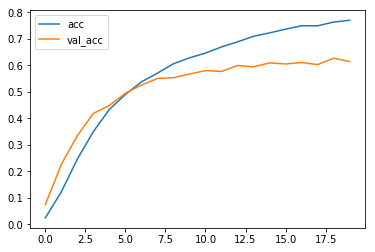

In [43]:
overfit_info.plot.line()

### Apart from last layer, training one more layer

In [15]:
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.layers import Dense,GlobalAveragePooling2D, Flatten,Dropout

vgg_model = VGG19(weights='imagenet', include_top=False)

x = vgg_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
out = Dense(120, activation='softmax')(x)

model_few_layers = Model(inputs=vgg_model.input, outputs=out)

for layer in vgg_model.layers[:-1]:
    layer.trainable = False

for layer in vgg_model.layers[-1:]:
    layer.trainable = True

from keras.optimizers import Adam
opt = Adam()

model_few_layers.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model_few_layers.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [18]:
history_few_layers = model_few_layers.fit(X,Y,batch_size=256,epochs=20,validation_split=0.2,verbose=2,callbacks=[earlystop])
model_few_layers.save('modelfewlayer.h5')

Train on 8177 samples, validate on 2045 samples
Epoch 1/20
 - 177s - loss: 13.7888 - acc: 0.0257 - val_loss: 10.7067 - val_acc: 0.0905
Epoch 2/20
 - 135s - loss: 11.2785 - acc: 0.0939 - val_loss: 8.2084 - val_acc: 0.2171
Epoch 3/20
 - 136s - loss: 9.1731 - acc: 0.1863 - val_loss: 6.6941 - val_acc: 0.3110
Epoch 4/20
 - 136s - loss: 7.5388 - acc: 0.2710 - val_loss: 5.5724 - val_acc: 0.3667
Epoch 5/20
 - 136s - loss: 6.2813 - acc: 0.3440 - val_loss: 4.7478 - val_acc: 0.4225
Epoch 6/20
 - 136s - loss: 5.3405 - acc: 0.4083 - val_loss: 4.1198 - val_acc: 0.4694
Epoch 7/20
 - 136s - loss: 4.6260 - acc: 0.4582 - val_loss: 3.8513 - val_acc: 0.4939
Epoch 8/20
 - 136s - loss: 4.1823 - acc: 0.4983 - val_loss: 3.5633 - val_acc: 0.5247
Epoch 9/20
 - 136s - loss: 3.8248 - acc: 0.5266 - val_loss: 3.3768 - val_acc: 0.5550
Epoch 10/20
 - 136s - loss: 3.4999 - acc: 0.5480 - val_loss: 3.2600 - val_acc: 0.5423
Epoch 11/20
 - 136s - loss: 3.1300 - acc: 0.5797 - val_loss: 2.9761 - val_acc: 0.5731
Epoch 12/20


In [19]:
val_acc = history_few_layers.history.get('val_acc')

In [20]:
acc = history_few_layers.history.get('acc')

In [21]:
overfit_info = pd.DataFrame({'acc':acc, 'val_acc':val_acc})

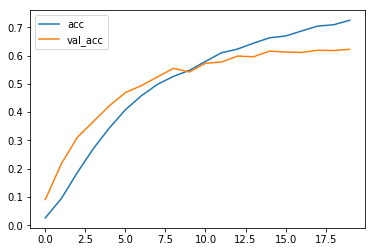

In [22]:
overfit_info.plot.line()

In [27]:
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.layers import Dense,GlobalAveragePooling2D, Flatten,Dropout

vgg_model = VGG19(weights='imagenet', include_top=False)

x = vgg_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
out = Dense(120, activation='softmax')(x)

model_few2_layers = Model(inputs=vgg_model.input, outputs=out)

for layer in vgg_model.layers[:-2]:
    layer.trainable = False

for layer in vgg_model.layers[-2:]:
    layer.trainable = True

from keras.optimizers import Adam
opt = Adam()

model_few2_layers.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model_few2_layers.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [28]:
history_few2_layers = model_few2_layers.fit(X,Y,batch_size=256,epochs=20,validation_split=0.2,verbose=2)
model_few2_layers.save('modelfew2layer.h5')

Train on 8177 samples, validate on 2045 samples
Epoch 1/20
 - 137s - loss: 15.0389 - acc: 0.0440 - val_loss: 14.5606 - val_acc: 0.0831
Epoch 2/20
 - 137s - loss: 14.4771 - acc: 0.0827 - val_loss: 13.7797 - val_acc: 0.1208
Epoch 3/20
 - 137s - loss: 13.4738 - acc: 0.1365 - val_loss: 12.4639 - val_acc: 0.1814
Epoch 4/20
 - 137s - loss: 9.1730 - acc: 0.1662 - val_loss: 4.2871 - val_acc: 0.1359
Epoch 5/20
 - 137s - loss: 3.6227 - acc: 0.2044 - val_loss: 2.7911 - val_acc: 0.3384
Epoch 6/20
 - 137s - loss: 2.3950 - acc: 0.4056 - val_loss: 2.0131 - val_acc: 0.4577
Epoch 7/20
 - 137s - loss: 1.6561 - acc: 0.5522 - val_loss: 1.7692 - val_acc: 0.5159
Epoch 8/20
 - 137s - loss: 1.2442 - acc: 0.6482 - val_loss: 1.7068 - val_acc: 0.5443
Epoch 9/20
 - 137s - loss: 0.9561 - acc: 0.7218 - val_loss: 1.6001 - val_acc: 0.5770
Epoch 10/20
 - 137s - loss: 0.7386 - acc: 0.7773 - val_loss: 1.5761 - val_acc: 0.5653
Epoch 11/20
 - 137s - loss: 0.5731 - acc: 0.8296 - val_loss: 1.5571 - val_acc: 0.5907
Epoch 12/

In [29]:
val_acc = history_few2_layers.history.get('val_acc')

In [30]:
acc = history_few2_layers.history.get('acc')

In [31]:
overfit_info = pd.DataFrame({'acc':acc, 'val_acc':val_acc})

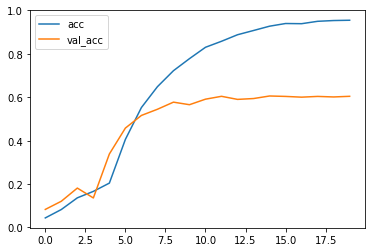

In [32]:
overfit_info.plot.line()

### Verifying models for top 3 prediction on Training Data

In [33]:
from keras.models import load_model

In [43]:
def validate(X,Y):
    for model_img in ['modellastlayer.h5','modelfewlayer.h5','modelfew2layer.h5']:
        model = load_model(model_img)
        pred = model.predict(X)
        top3 = np.argsort(pred)[:,-3:]
        actual = np.argmax(Y,axis=1)
        res = top3 - actual.reshape(-1,1)
        ana = np.product(res,axis=1)
        print (model_img, np.sum(ana == 0)/ana.shape[0])

modellastlayer.h5 0.9110741537859519
modelfewlayer.h5 0.9151829387595383
modelfew2layer.h5 0.9631187634513794


### Validating models with new data - 5 files for each type

In [61]:
test_labels = pd.read_csv('test_labels.csv',index_col='Unnamed: 0')

In [62]:
test_labels.rename(columns={'files':'id'},inplace=True)

In [64]:
test_labels.head()

,breed,id
0,chihuahua,n02085620_10074
1,chihuahua,n02085620_10131
2,chihuahua,n02085620_10621
3,chihuahua,n02085620_1073
4,chihuahua,n02085620_10976


In [65]:
breed = le.transform(test_labels.breed)
Y = np_utils.to_categorical(breed,num_classes=num_classes)

In [67]:
base_dir = '.'
data_dir = os.path.join(base_dir,'Test-Dog-Breed/')
files = os.listdir(data_dir)

In [69]:
input_dim = (224, 224)

X = np.zeros((Y.shape[0],*input_dim,3))

for i,img in enumerate(files):
    image = load_img(os.path.join(data_dir,img),target_size=input_dim)
    image = img_to_array(image)
    image = image.reshape((1, *image.shape))
    image = preprocess_input(image)
    X[i] = image

In [85]:
X[0]

array([[[ -74.93900299,  -83.77899933,  -89.68000031],
        [ -95.93900299,  -98.77899933, -105.68000031],
        [ -89.93900299,  -86.77899933,  -94.68000031],
        ...,
        [ -35.93900299,  -50.77899933,  -57.68000031],
        [ -36.93900299,  -45.77899933,  -57.68000031],
        [ -67.93900299,  -76.77899933,  -88.68000031]],

       [[ -87.93900299, -100.77899933, -107.68000031],
        [ -88.93900299,  -96.77899933, -104.68000031],
        [  -8.93900299,   -8.77899933,  -17.68000031],
        ...,
        [ -35.93900299,  -48.77899933,  -55.68000031],
        [ -30.93900299,  -40.77899933,  -49.68000031],
        [ -59.93900299,  -69.77899933,  -78.68000031]],

       [[ -48.93900299,  -70.77899933,  -80.68000031],
        [ -31.93900299,  -47.77899933,  -58.68000031],
        [ -51.93900299,  -60.77899933,  -72.68000031],
        ...,
        [ -65.93900299,  -73.77899933,  -81.68000031],
        [  -1.93900299,  -12.77899933,  -19.68000031],
        [ -83.93900299

In [86]:
def validate(X,Y):
    for model_img in ['modellastlayer.h5','modelfewlayer.h5','modelfew2layer.h5']:
        model = load_model(model_img)
        pred = model.predict(X)
        top3 = np.argsort(pred)[:,-3:]
        actual = np.argmax(Y,axis=1)
        res = top3 - actual.reshape(-1,1)
        ana = np.product(res,axis=1)
        print (model_img, np.sum(ana == 0)/ana.shape[0])

In [87]:
validate(X,Y)

modellastlayer.h5 0.9110741537859519
modelfewlayer.h5 0.9151829387595383
modelfew2layer.h5 0.9631187634513794


In [137]:
model = load_model('modelfewlayer.h5')

In [153]:
image = load_img('Test-Dog-Breed/n02085620_1',target_size=input_dim)
image = img_to_array(image)
image = image.reshape((1, *image.shape))
image = preprocess_input(image)

In [149]:
image.shape

(1, 224, 224, 3)

In [154]:
res = model.predict(image)

In [156]:
s = np.argsort(res)[0][-5:]
s

array([101,  43,  86, 111,  29])

In [157]:
le.inverse_transform(s)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array(['siberian_husky', 'eskimo_dog', 'pembroke', 'toy_terrier',
       'chihuahua'], dtype=object)

### Image Augmentation

In [13]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

In [14]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

In [15]:
datagen.fit(X)

In [20]:
model = load_model('modelfewlayer.h5')

In [22]:
history_aug_images = model.fit_generator(datagen.flow(X, Y, batch_size=256), steps_per_epoch=len(X) / 32, epochs=20, verbose=2)

Epoch 1/20
 - 1032s - loss: 2.5376 - acc: 0.5324
Epoch 2/20
 - 1030s - loss: 2.3382 - acc: 0.5551
Epoch 3/20
 - 1030s - loss: 2.1625 - acc: 0.5772
Epoch 4/20
 - 1031s - loss: 2.0090 - acc: 0.5945
Epoch 5/20
 - 1031s - loss: 1.8824 - acc: 0.6081
Epoch 6/20
 - 1031s - loss: 1.7673 - acc: 0.6236
Epoch 7/20
 - 1032s - loss: 1.6673 - acc: 0.6340
Epoch 8/20
 - 1032s - loss: 1.5892 - acc: 0.6389
Epoch 9/20
 - 1031s - loss: 1.5121 - acc: 0.6486
Epoch 10/20
 - 1030s - loss: 1.4401 - acc: 0.6579
Epoch 11/20
 - 1029s - loss: 1.3802 - acc: 0.6671
Epoch 12/20
 - 1030s - loss: 1.3270 - acc: 0.6743
Epoch 13/20
 - 1030s - loss: 1.2780 - acc: 0.6827
Epoch 14/20
 - 1030s - loss: 1.2368 - acc: 0.6871
Epoch 15/20
 - 1029s - loss: 1.1985 - acc: 0.6917
Epoch 16/20
 - 1029s - loss: 1.1656 - acc: 0.6978
Epoch 17/20
 - 1030s - loss: 1.1331 - acc: 0.7004
Epoch 18/20
 - 1030s - loss: 1.1070 - acc: 0.7042
Epoch 19/20
 - 1029s - loss: 1.0823 - acc: 0.7088
Epoch 20/20
 - 1030s - loss: 1.0595 - acc: 0.7121


In [23]:
history_aug_images.history.keys()

dict_keys(['loss', 'acc'])

In [24]:
model.save('img_aug.h5')

In [37]:
model = load_model('img_aug.h5')
image = load_img('gullu.jpg',target_size=input_dim)
image = img_to_array(image)
image = image.reshape((1, *image.shape))
image = preprocess_input(image)

In [38]:
res = model.predict(image)

In [39]:
s = np.argsort(res)[0][-5:]
s

array([90, 32, 86, 67, 49])

In [40]:
le.inverse_transform(s)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array(['rhodesian_ridgeback', 'cocker_spaniel', 'pembroke',
       'labrador_retriever', 'golden_retriever'], dtype=object)

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
trainX,testX,trainY,testY = train_test_split(X,Y)

In [17]:
trainY.shape

(7666, 120)

In [18]:
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.layers import Dense,GlobalAveragePooling2D, Flatten,Dropout

vgg_model = VGG19(weights='imagenet', include_top=False)

x = vgg_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
out = Dense(120, activation='softmax')(x)

model_few1_layers = Model(inputs=vgg_model.input, outputs=out)

for layer in vgg_model.layers[:-1]:
    layer.trainable = False

for layer in vgg_model.layers[-1:]:
    layer.trainable = True

from keras.optimizers import Adam
opt = Adam()

model_few1_layers.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model_few1_layers.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [23]:
datagen.fit(trainX)

In [26]:
history_aug_images = model_few1_layers.fit_generator(datagen.flow(trainX, trainY, batch_size=256), steps_per_epoch=len(X) / 32, epochs=20, verbose=1, validation_data=(testX,testY))

Epoch 1/20
320/319 [==============================] - 1103s 3s/step - loss: 3.5373 - acc: 0.2931 - val_loss: 5.2916 - val_acc: 0.5372
Epoch 2/20
320/319 [==============================] - 1061s 3s/step - loss: 2.2431 - acc: 0.5517 - val_loss: 4.8868 - val_acc: 0.6013
Epoch 3/20
320/319 [==============================] - 1061s 3s/step - loss: 1.7948 - acc: 0.6163 - val_loss: 4.8068 - val_acc: 0.6201
Epoch 4/20
320/319 [==============================] - 1061s 3s/step - loss: 1.5636 - acc: 0.6480 - val_loss: 4.7402 - val_acc: 0.6362
Epoch 5/20
320/319 [==============================] - 1061s 3s/step - loss: 1.4154 - acc: 0.6685 - val_loss: 4.7023 - val_acc: 0.6408
Epoch 6/20
320/319 [==============================] - 1061s 3s/step - loss: 1.3175 - acc: 0.6832 - val_loss: 4.7534 - val_acc: 0.6451
Epoch 7/20
320/319 [==============================] - 1061s 3s/step - loss: 1.2352 - acc: 0.6972 - val_loss: 4.7830 - val_acc: 0.6459
Epoch 8/20
320/319 [==============================] - 1061s 3s

In [27]:
model_few1_layers.save('model_aug1_layer.h5')

In [16]:
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.layers import Dense,GlobalAveragePooling2D, Flatten,Dropout

vgg_model = VGG19(weights='imagenet', include_top=False)

x = vgg_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
out = Dense(120, activation='softmax')(x)

model_few2_layers = Model(inputs=vgg_model.input, outputs=out)

for layer in vgg_model.layers[:-2]:
    layer.trainable = False

for layer in vgg_model.layers[-2:]:
    layer.trainable = True

from keras.optimizers import Adam
opt = Adam()

model_few2_layers.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model_few2_layers.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [19]:
history_aug2_images = model_few2_layers.fit_generator(datagen.flow(trainX, trainY, batch_size=256), steps_per_epoch=len(X) / 32, epochs=10, verbose=1, validation_data=(testX,testY))
model_few2_layers.save('model_aug2_layer.h5')

Epoch 1/10
320/319 [==============================] - 1123s 4s/step - loss: 1.7026 - acc: 0.5560 - val_loss: 5.2118 - val_acc: 0.6295
Epoch 2/10
320/319 [==============================] - 1079s 3s/step - loss: 0.6987 - acc: 0.7964 - val_loss: 5.2839 - val_acc: 0.6408
Epoch 3/10
320/319 [==============================] - 1079s 3s/step - loss: 0.4129 - acc: 0.8807 - val_loss: 5.3397 - val_acc: 0.6444
Epoch 4/10
320/319 [==============================] - 1079s 3s/step - loss: 0.2789 - acc: 0.9209 - val_loss: 5.4454 - val_acc: 0.6362
Epoch 5/10
320/319 [==============================] - 1079s 3s/step - loss: 0.1981 - acc: 0.9458 - val_loss: 5.5338 - val_acc: 0.6365
Epoch 6/10
320/319 [==============================] - 1088s 3s/step - loss: 0.1516 - acc: 0.9590 - val_loss: 5.5260 - val_acc: 0.6381
Epoch 7/10
320/319 [==============================] - 1079s 3s/step - loss: 0.1230 - acc: 0.9678 - val_loss: 5.3346 - val_acc: 0.6467
Epoch 8/10
320/319 [==============================] - 1079s 3s

In [20]:
model_few2_layers.save('model_aug2_layer.h5')

In [41]:
image = load_img('gullu.jpg',target_size=input_dim)
image = img_to_array(image)
image = image.reshape((1, *image.shape))
image = preprocess_input(image)

In [42]:
res = model_few2_layers.predict(image)

In [43]:
s = np.argsort(res)[0][-5:]
s

array([119, 112,  90,  49,  67])

In [44]:
le.inverse_transform(s)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array(['yorkshire_terrier', 'vizsla', 'rhodesian_ridgeback',
       'golden_retriever', 'labrador_retriever'], dtype=object)

### Last layer Trained

In [27]:
last_layer_model = load_model('modellastlayer.h5')

In [28]:
res = last_layer_model.predict(image)

In [29]:
s = np.argsort(res)[0][-5:]
s

array([28, 85, 79, 32, 49])

In [30]:
le.inverse_transform(s)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array(['chesapeake_bay_retriever', 'pekinese', 'norfolk_terrier',
       'cocker_spaniel', 'golden_retriever'], dtype=object)

In [31]:
last_2_layer_model = load_model('modelfew2layer.h5')

In [32]:
res = last_layer_model.predict(image)

In [33]:
s = np.argsort(res)[0][-5:]
s

array([28, 85, 79, 32, 49])

In [34]:
le.inverse_transform(s)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array(['chesapeake_bay_retriever', 'pekinese', 'norfolk_terrier',
       'cocker_spaniel', 'golden_retriever'], dtype=object)